# Review Summarization Tutorial

In this tutorial, we will build a review summarization feature similar to Amazon's review highlights. We will use NLTK for text preprocessing, identify common bigrams (two-word phrases), analyze their sentiment, and cluster them using Word2Vec.

**Goal:** Show meaningful analysis/feature outcome from simple bigram probabilities.

**Steps:**
1. EDA and Text Preprocessing using NLTK
2. Identify most common bigrams
3. Identify bigram probabilities for positive/negative reviews
4. Use Word2Vec for clustering
5. Draw conclusions


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from collections import Counter
import gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.cluster import KMeans

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gauravmapari/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nl

True

## Load Data
We will load the reviews and items datasets.


In [2]:
df_reviews = pd.read_csv("20191226-reviews.csv")
df_items = pd.read_csv("20191226-items.csv")

print("Reviews shape:", df_reviews.shape)
print("Items shape:", df_items.shape)
df_reviews.head()


Reviews shape: (67986, 8)
Items shape: (720, 10)


,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


## Step 1: EDA and Text Preprocessing
We'll start by exploring the rating distribution and then preprocess the text data.


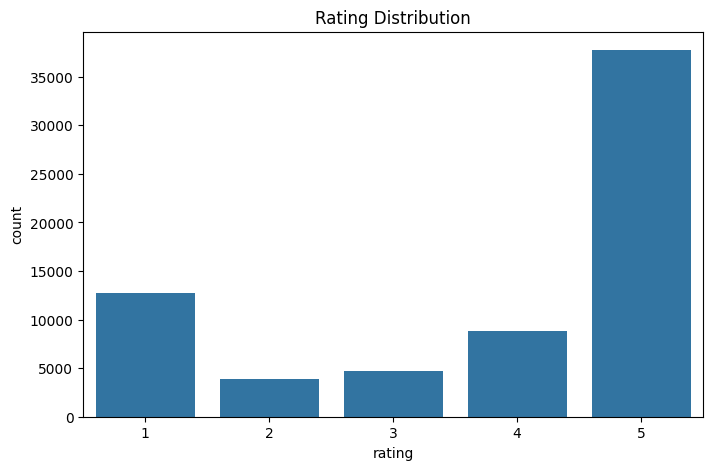

In [3]:
# Rating Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df_reviews)
plt.title('Rating Distribution')
plt.show()


### Text Preprocessing
We will perform the following steps:
1. **Tokenization:** Splitting text into words.
2. **Lowercasing:** Converting all text to lower case.
3. **Stopword Removal:** Removing common words like 'the', 'is', 'and' that don't carry much meaning.
4. **Lemmatization:** Converting words to their base form (e.g., 'batteries' -> 'battery').
5. **Filtering:** Keeping only alphabetic tokens.


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Noun POS tags we're interested in (NN=singular noun, NNS=plural noun, NNP/NNPS=proper nouns)
NOUN_TAGS = {'NN', 'NNS', 'NNP', 'NNPS'}

def preprocess_text(text):
    """Tokenize, lowercase, remove stopwords, and lemmatize."""
    if not isinstance(text, str):
        return []
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords and non-alphabetic tokens, lemmatize
    clean_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return clean_tokens

def extract_nouns(text):
    """Extract nouns from text using POS tagging."""
    if not isinstance(text, str):
        return []
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    # POS tag the tokens
    tagged = nltk.pos_tag(tokens)
    # Extract nouns, lemmatize, and filter
    nouns = [
        lemmatizer.lemmatize(word) 
        for word, tag in tagged 
        if tag in NOUN_TAGS and word.isalpha() and word not in stop_words and len(word) > 2
    ]
    return nouns

# Apply preprocessing (using a subset for speed if needed, but here we do all)
# Dropping rows with missing body
df_reviews = df_reviews.dropna(subset=['body'])
df_reviews['clean_tokens'] = df_reviews['body'].apply(preprocess_text)
df_reviews['nouns'] = df_reviews['body'].apply(extract_nouns)

print("Sample output:")
df_reviews[['body', 'clean_tokens', 'nouns']].head()


Sample output:


,body,clean_tokens,nouns
0,I had the Samsung A600 for awhile which is abs...,"[samsung, awhile, absolute, doo, doo, read, re...","[samsung, awhile, doo, doo, review, rage, thin..."
1,Due to a software issue between Nokia and Spri...,"[due, software, issue, nokia, sprint, phone, t...","[software, issue, sprint, phone, text, messagi..."
2,"This is a great, reliable phone. I also purcha...","[great, reliable, phone, also, purchased, phon...","[phone, phone, samsung, menu, speed, dialing, ..."
3,"I love the phone and all, because I really did...","[love, phone, really, need, one, expect, price...","[phone, price, bill, phone, month, accessory, ..."
4,The phone has been great for every purpose it ...,"[phone, great, every, purpose, offer, except, ...","[phone, purpose, day, couldnt, case, case, pic..."


## Step 2: Extract Candidate Aspect Features

To automatically discover aspects like "Battery life", "Performance", "Value", we extract two types of features:
1. **Top Nouns (Unigrams):** Single words like "battery", "price", "performance" - these represent core aspects.
2. **Top Bigrams:** Two-word phrases like "battery life", "camera quality" - these represent specific features.

We combine these into a list of **candidate aspect features** for clustering.


In [5]:
def get_bigrams(tokens_list):
    """Extract all bigrams from a list of token lists."""
    all_bigrams = []
    for tokens in tokens_list:
        all_bigrams.extend(list(ngrams(tokens, 2)))
    return all_bigrams

# --- Extract Top Nouns ---
all_nouns = []
for noun_list in df_reviews['nouns']:
    all_nouns.extend(noun_list)
noun_counts = Counter(all_nouns)

# Filter nouns with minimum frequency (to focus on common aspects)
MIN_NOUN_COUNT = 50
top_nouns = [(noun, count) for noun, count in noun_counts.most_common(100) if count >= MIN_NOUN_COUNT]

print(f"Top Nouns (min count {MIN_NOUN_COUNT}):")
for noun, count in top_nouns[:20]:
    print(f"  {noun}: {count}")

# --- Extract Top Bigrams ---
bigrams = get_bigrams(df_reviews['clean_tokens'])
bigram_counts = Counter(bigrams)

MIN_BIGRAM_COUNT = 30
top_bigrams = [(bg, count) for bg, count in bigram_counts.most_common(100) if count >= MIN_BIGRAM_COUNT]

print(f"\nTop Bigrams (min count {MIN_BIGRAM_COUNT}):")
for bg, count in top_bigrams[:20]:
    print(f"  {bg[0]} {bg[1]}: {count}")

# --- Combine into Candidate Features ---
# Store as unified format: (feature_type, feature, count)
candidate_features = []
for noun, count in top_nouns:
    candidate_features.append(('noun', noun, count))
for bg, count in top_bigrams:
    candidate_features.append(('bigram', bg, count))

print(f"\n✓ Total candidate features: {len(candidate_features)} ({len(top_nouns)} nouns + {len(top_bigrams)} bigrams)")


Top Nouns (min count 50):
  phone: 105622
  battery: 15047
  screen: 13865
  camera: 11101
  time: 9803
  day: 8759
  price: 7346
  issue: 6778
  life: 6724
  samsung: 6614
  problem: 6340
  card: 5924
  quality: 5761
  month: 5481
  thing: 5409
  apps: 5130
  iphone: 5105
  device: 5084
  product: 5068
  feature: 5054

Top Bigrams (min count 30):
  battery life: 5912
  great phone: 4324
  sim card: 3365
  love phone: 2732
  new phone: 2510
  phone work: 2467
  work great: 2190
  brand new: 2120
  phone great: 2039
  good phone: 2002
  bought phone: 1496
  work well: 1390
  sd card: 1363
  window phone: 1335
  best phone: 1328
  like new: 1322
  cell phone: 1283
  use phone: 1263
  phone ever: 1223
  phone would: 1150

✓ Total candidate features: 200 (100 nouns + 100 bigrams)


## Step 3: Calculate Sentiment Probabilities for All Features

We calculate sentiment probabilities for **both nouns and bigrams**.
- **Positive:** rating > 3
- **Negative:** rating <= 3

This allows us to later aggregate sentiment by aspect cluster.


In [6]:
# Define Sentiment
df_reviews['sentiment'] = df_reviews['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')

# Separate positive and negative reviews
pos_df = df_reviews[df_reviews['sentiment'] == 'positive']
neg_df = df_reviews[df_reviews['sentiment'] == 'negative']

# --- Noun Sentiment Counts ---
pos_nouns = []
for noun_list in pos_df['nouns']:
    pos_nouns.extend(noun_list)
neg_nouns = []
for noun_list in neg_df['nouns']:
    neg_nouns.extend(noun_list)

pos_noun_counts = Counter(pos_nouns)
neg_noun_counts = Counter(neg_nouns)

# --- Bigram Sentiment Counts ---
pos_bigrams = get_bigrams(pos_df['clean_tokens'])
neg_bigrams = get_bigrams(neg_df['clean_tokens'])

pos_bigram_counts = Counter(pos_bigrams)
neg_bigram_counts = Counter(neg_bigrams)

# --- Build Feature Sentiment DataFrame ---
# Store sentiment stats for ALL candidate features
feature_sentiment_data = []

for feat_type, feature, total_count in candidate_features:
    if feat_type == 'noun':
        p_count = pos_noun_counts[feature]
        n_count = neg_noun_counts[feature]
        feature_str = feature
    else:  # bigram
        p_count = pos_bigram_counts[feature]
        n_count = neg_bigram_counts[feature]
        feature_str = f"{feature[0]}_{feature[1]}"
    
    total = p_count + n_count
    if total > 0:
        feature_sentiment_data.append({
            'type': feat_type,
            'feature': feature_str,
            'feature_display': feature if feat_type == 'noun' else f"{feature[0]} {feature[1]}",
            'positive': p_count,
            'negative': n_count,
            'total': total,
            'pos_ratio': p_count / total
        })

df_feature_sentiment = pd.DataFrame(feature_sentiment_data)
df_feature_sentiment = df_feature_sentiment.sort_values('total', ascending=False)

print("Top 15 Features by Total Mentions:")
print(df_feature_sentiment[['feature_display', 'positive', 'negative', 'total', 'pos_ratio']].head(15).to_string(index=False))


Top 15 Features by Total Mentions:
feature_display  positive  negative  total  pos_ratio
          phone     65198     40424 105622   0.617277
        battery      9782      5265  15047   0.650096
         screen      8357      5508  13865   0.602741
         camera      8440      2661  11101   0.760292
           time      5468      4335   9803   0.557788
            day      5385      3374   8759   0.614796
          price      6185      1161   7346   0.841955
          issue      3541      3237   6778   0.522425
           life      5031      1693   6724   0.748215
        samsung      3966      2648   6614   0.599637
        problem      3370      2970   6340   0.531546
           card      3734      2190   5924   0.630317
   battery life      4477      1435   5912   0.757273
        quality      4321      1440   5761   0.750043
          month      2137      3344   5481   0.389892


### Visualize Sentiment Breakdown
This stacked bar chart shows the number of positive and negative mentions for the top features.


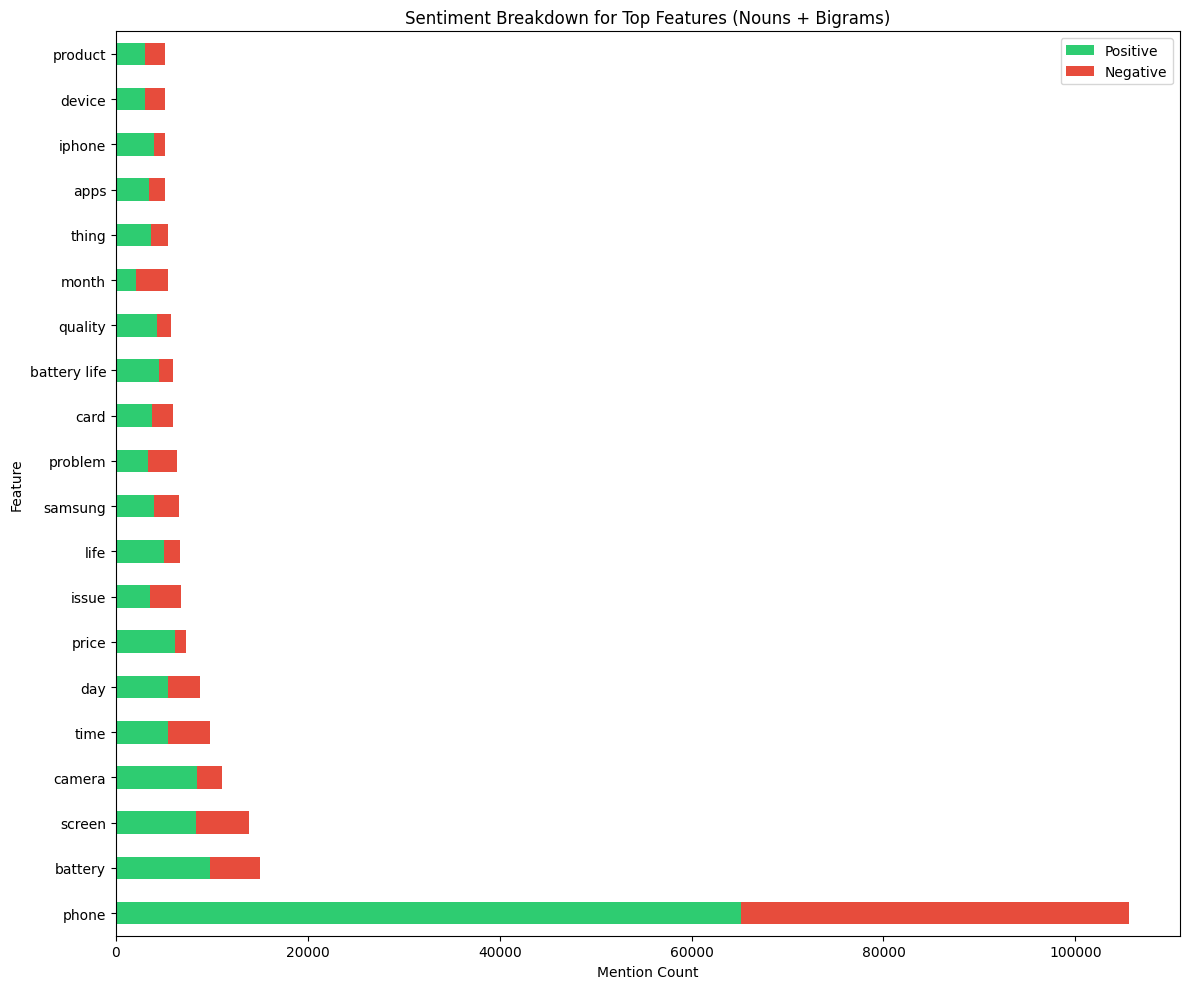

In [7]:
top_features_viz = df_feature_sentiment.head(20).copy()
top_features_viz.set_index('feature_display')[['positive', 'negative']].plot(
    kind='barh', stacked=True, figsize=(12, 10), color=['#2ecc71', '#e74c3c']
)
plt.title('Sentiment Breakdown for Top Features (Nouns + Bigrams)')
plt.xlabel('Mention Count')
plt.ylabel('Feature')
plt.legend(['Positive', 'Negative'])
plt.tight_layout()
plt.show()


## Step 4: Aspect Discovery via Word2Vec Clustering

We use Word2Vec to learn semantic representations and then cluster **all candidate features** (nouns + bigrams) to discover high-level aspects.

**Goal:** Group related terms like:
- "battery", "charge", "battery life" → **Battery** aspect
- "price", "value", "money" → **Value** aspect
- "screen", "display", "display quality" → **Display** aspect


In [8]:
# Detect phrases (bigrams) using Gensim Phrases
phrases = Phrases(df_reviews['clean_tokens'], min_count=5, threshold=10)
bigram_phraser = Phraser(phrases)

# Transform sentences to include detected bigrams as single tokens
bigram_sentences = [bigram_phraser[sent] for sent in df_reviews['clean_tokens']]

# Train Word2Vec on the phraser-transformed sentences
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=bigram_sentences, vector_size=100, window=5, min_count=5, workers=4)
print(f"Vocabulary size: {len(w2v_model.wv)}")

# --- Get Vectors for ALL Candidate Features ---
feature_vectors = []
feature_names = []
feature_types = []

for feat_type, feature, count in candidate_features:
    if feat_type == 'noun':
        # Single word - look up directly
        if feature in w2v_model.wv:
            feature_vectors.append(w2v_model.wv[feature])
            feature_names.append(feature)
            feature_types.append('noun')
    else:
        # Bigram - try joined form first, then average
        bg_joined = f"{feature[0]}_{feature[1]}"
        if bg_joined in w2v_model.wv:
            feature_vectors.append(w2v_model.wv[bg_joined])
            feature_names.append(bg_joined)
            feature_types.append('bigram')
        elif feature[0] in w2v_model.wv and feature[1] in w2v_model.wv:
            # Fallback: average of individual word vectors
            vec = (w2v_model.wv[feature[0]] + w2v_model.wv[feature[1]]) / 2
            feature_vectors.append(vec)
            feature_names.append(bg_joined)
            feature_types.append('bigram')

feature_vectors = np.array(feature_vectors)
print(f"\n✓ Vectorized {len(feature_vectors)} features ({sum(1 for t in feature_types if t=='noun')} nouns, {sum(1 for t in feature_types if t=='bigram')} bigrams)")


Training Word2Vec model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulary size: 14121

✓ Vectorized 200 features (100 nouns, 100 bigrams)


In [9]:
# Clustering with K-Means
NUM_CLUSTERS = 8  # Adjust based on desired granularity (more clusters = finer aspects)

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(feature_vectors)

# --- Build Cluster Map with Feature Info ---
# Map feature names back to their sentiment data
feature_to_sentiment = {row['feature']: row for _, row in df_feature_sentiment.iterrows()}

cluster_data = {}
for i, cluster_id in enumerate(cluster_labels):
    feat_name = feature_names[i]
    if cluster_id not in cluster_data:
        cluster_data[cluster_id] = {'features': [], 'total_mentions': 0}
    
    # Get sentiment info if available
    sentiment_info = feature_to_sentiment.get(feat_name, {})
    total = sentiment_info.get('total', 0)
    
    cluster_data[cluster_id]['features'].append({
        'name': feat_name,
        'type': feature_types[i],
        'total': total,
        'positive': sentiment_info.get('positive', 0),
        'negative': sentiment_info.get('negative', 0)
    })
    cluster_data[cluster_id]['total_mentions'] += total

# --- Auto-Label Clusters ---
# Use the most frequent term in each cluster as the label
cluster_labels_map = {}
for cluster_id, data in cluster_data.items():
    # Sort features by total mentions
    sorted_features = sorted(data['features'], key=lambda x: x['total'], reverse=True)
    if sorted_features:
        # Use the top feature as the cluster label
        top_feat = sorted_features[0]['name'].replace('_', ' ')
        cluster_labels_map[cluster_id] = top_feat.title()
    else:
        cluster_labels_map[cluster_id] = f"Cluster {cluster_id}"

# Display clusters
print("=" * 60)
print("DISCOVERED ASPECT CLUSTERS")
print("=" * 60)
for cluster_id in sorted(cluster_data.keys(), key=lambda x: cluster_data[x]['total_mentions'], reverse=True):
    data = cluster_data[cluster_id]
    label = cluster_labels_map[cluster_id]
    print(f"\n📦 {label} (Total mentions: {data['total_mentions']})")
    print("-" * 40)
    for feat in sorted(data['features'], key=lambda x: x['total'], reverse=True)[:8]:
        print(f"   • {feat['name'].replace('_', ' ')}: {feat['total']} mentions")


DISCOVERED ASPECT CLUSTERS

📦 Phone (Total mentions: 238055)
----------------------------------------
   • phone: 105622 mentions
   • issue: 6778 mentions
   • problem: 6340 mentions
   • thing: 5409 mentions
   • device: 5084 mentions
   • work: 4462 mentions
   • everything: 4370 mentions
   • great phone: 4324 mentions

📦 Screen (Total mentions: 88803)
----------------------------------------
   • screen: 13865 mentions
   • camera: 11101 mentions
   • price: 7346 mentions
   • life: 6724 mentions
   • battery life: 5912 mentions
   • quality: 5761 mentions
   • lot: 3526 mentions
   • button: 2695 mentions

📦 Battery (Total mentions: 58156)
----------------------------------------
   • battery: 15047 mentions
   • time: 9803 mentions
   • day: 8759 mentions
   • month: 5481 mentions
   • year: 4314 mentions
   • hour: 2889 mentions
   • week: 2884 mentions
   • update: 2776 mentions

📦 Samsung (Total mentions: 56103)
----------------------------------------
   • samsung: 6614 ment

## Step 5: Amazon-Style Aspect Summaries

Now we aggregate sentiment **by aspect cluster** to produce Amazon-style review highlights.

For each aspect, we show:
- Total number of mentions
- Positive vs Negative breakdown
- Key terms in that aspect


In [10]:
# --- Aggregate Sentiment by Aspect Cluster ---
aspect_summaries = []

for cluster_id, data in cluster_data.items():
    label = cluster_labels_map[cluster_id]
    
    # Sum up positive and negative across all features in the cluster
    total_pos = sum(f['positive'] for f in data['features'])
    total_neg = sum(f['negative'] for f in data['features'])
    total_mentions = total_pos + total_neg
    
    if total_mentions > 0:
        aspect_summaries.append({
            'aspect': label,
            'total': total_mentions,
            'positive': total_pos,
            'negative': total_neg,
            'pos_ratio': total_pos / total_mentions,
            'terms': [f['name'].replace('_', ' ') for f in sorted(data['features'], key=lambda x: x['total'], reverse=True)[:5]]
        })

# Sort by total mentions
aspect_summaries = sorted(aspect_summaries, key=lambda x: x['total'], reverse=True)

# --- Display Amazon-Style Summary ---
print("=" * 70)
print("📊 REVIEW HIGHLIGHTS (Amazon-Style)")
print("=" * 70)

for asp in aspect_summaries:
    pos_bar = "█" * int(asp['pos_ratio'] * 20)
    neg_bar = "░" * (20 - int(asp['pos_ratio'] * 20))
    
    print(f"\n🏷️  {asp['aspect']} ({asp['total']} mentions)")
    print(f"    {pos_bar}{neg_bar}  {asp['positive']} positive, {asp['negative']} negative")
    print(f"    Related terms: {', '.join(asp['terms'][:4])}")


📊 REVIEW HIGHLIGHTS (Amazon-Style)

🏷️  Phone (238055 mentions)
    ████████████░░░░░░░░  152201 positive, 85854 negative
    Related terms: phone, issue, problem, thing

🏷️  Screen (88803 mentions)
    ██████████████░░░░░░  65511 positive, 23292 negative
    Related terms: screen, camera, price, life

🏷️  Battery (58156 mentions)
    ███████████░░░░░░░░░  33161 positive, 24995 negative
    Related terms: battery, time, day, month

🏷️  Samsung (56103 mentions)
    █████████████░░░░░░░  37805 positive, 18298 negative
    Related terms: samsung, iphone, note, galaxy

🏷️  Apps (32419 mentions)
    ██████████████░░░░░░  22813 positive, 9606 negative
    Related terms: apps, feature, picture, app

🏷️  Product (28421 mentions)
    ██████████░░░░░░░░░░  15336 positive, 13085 negative
    Related terms: product, review, seller, money

🏷️  Card (27330 mentions)
    ███████████░░░░░░░░░  15730 positive, 11600 negative
    Related terms: card, verizon, sim card, service

🏷️  Case (8841 mentions)


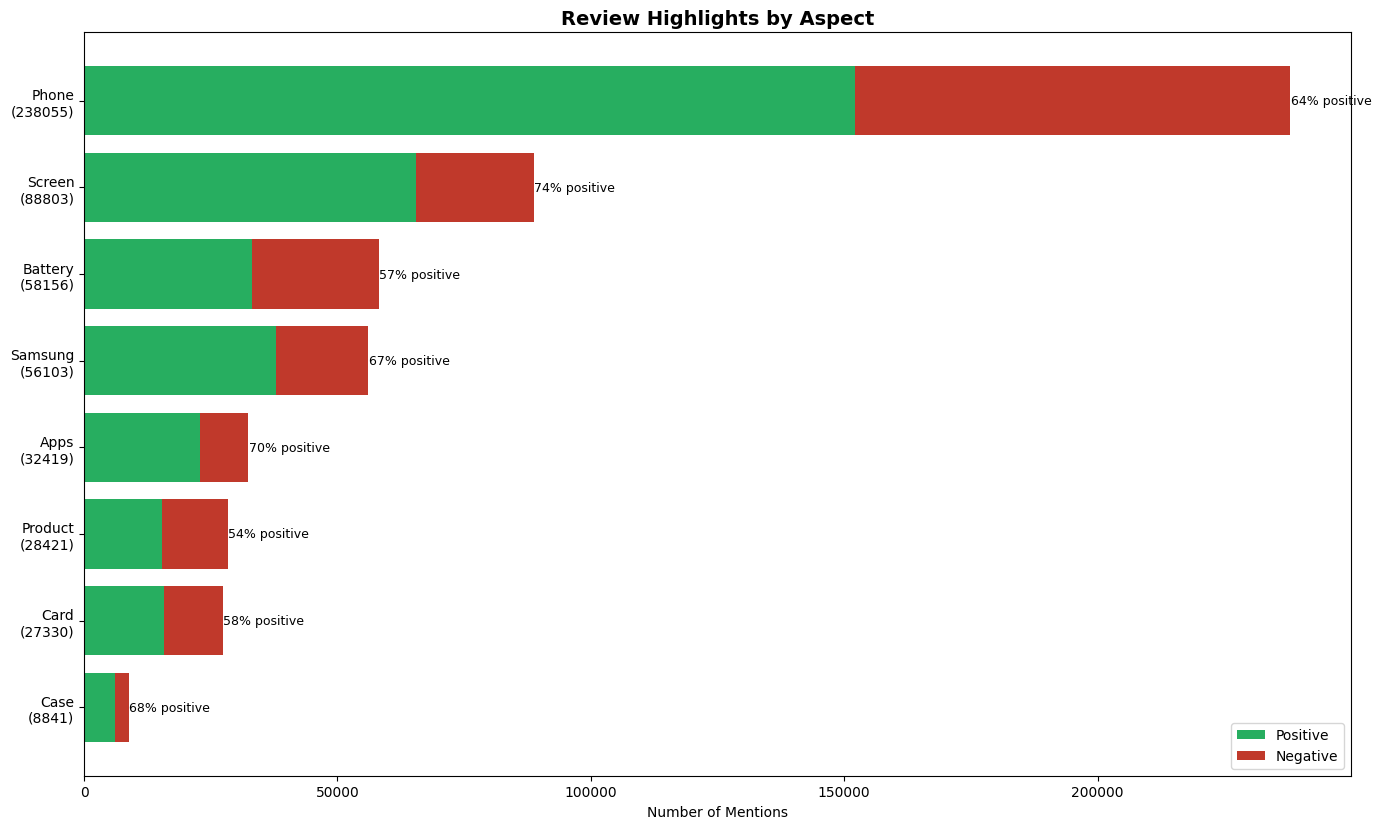

In [11]:
# --- Visualization: Aspect Summary Cards ---
fig, ax = plt.subplots(figsize=(14, len(aspect_summaries) * 0.8 + 2))

# Prepare data
aspects = [a['aspect'] for a in aspect_summaries]
positives = [a['positive'] for a in aspect_summaries]
negatives = [a['negative'] for a in aspect_summaries]

y_pos = np.arange(len(aspects))

# Create horizontal stacked bar
bars_pos = ax.barh(y_pos, positives, color='#27ae60', label='Positive')
bars_neg = ax.barh(y_pos, negatives, left=positives, color='#c0392b', label='Negative')

# Add labels
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{a['aspect']}\n({a['total']})" for a in aspect_summaries])
ax.set_xlabel('Number of Mentions')
ax.set_title('Review Highlights by Aspect', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')

# Add percentage labels
for i, asp in enumerate(aspect_summaries):
    total = asp['total']
    pct = asp['pos_ratio'] * 100
    ax.text(total + 50, i, f"{pct:.0f}% positive", va='center', fontsize=9)

plt.tight_layout()
plt.gca().invert_yaxis()  # Highest at top
plt.show()

## Conclusions

### What We Built
We created an **unsupervised pipeline** for extracting review highlights, similar to Amazon's feature.

### Key NLP Techniques Used
1. **Text Preprocessing (NLTK):** Tokenization, stopword removal, lemmatization
2. **POS Tagging:** Extracted nouns as candidate aspect terms
3. **N-gram Analysis:** Identified meaningful bigrams (e.g., "battery life")
4. **Word2Vec Embeddings:** Learned semantic relationships between terms
5. **K-Means Clustering:** Grouped related terms into aspects

### Why This Works
- **Bigram probabilities** (from the bigram formula) help us understand which terms co-occur
- **Semantic clustering** groups synonymous/related terms (e.g., "screen", "display", "pixel")
- **Aggregation by cluster** produces meaningful aspect-level summaries

### Generalization
This pipeline works for **any product category**:
- For laptops: discovers "keyboard", "trackpad", "build quality"
- For headphones: discovers "sound quality", "noise cancellation", "comfort"
- For restaurants: discovers "food quality", "service", "ambiance"

The aspects emerge from the data itself - no predefined categories needed!

### Drill-Down: Explore a Specific Aspect
Similar to clicking on an aspect in Amazon's review highlights.

In [12]:
def show_aspect_details(aspect_name):
    """Show detailed breakdown for a specific aspect (Amazon drill-down style)."""
    # Find the aspect
    asp = next((a for a in aspect_summaries if a['aspect'].lower() == aspect_name.lower()), None)
    if not asp:
        print(f"Aspect '{aspect_name}' not found. Available: {[a['aspect'] for a in aspect_summaries]}")
        return
    
    print("=" * 60)
    print(f"📋 {asp['aspect'].upper()}")
    print("=" * 60)
    print(f"\n{asp['total']} customers mention \"{asp['aspect']}\"")
    print(f"  ✅ {asp['positive']} positive ({asp['pos_ratio']*100:.0f}%)")
    print(f"  ❌ {asp['negative']} negative ({(1-asp['pos_ratio'])*100:.0f}%)")
    
    # Find sample reviews mentioning these terms
    terms = asp['terms']
    search_pattern = '|'.join(terms)
    
    # Get positive examples
    print(f"\n--- Positive Reviews ---")
    pos_samples = df_reviews[(df_reviews['sentiment'] == 'positive') & 
                             (df_reviews['body'].str.lower().str.contains(search_pattern, na=False))].head(3)
    for _, row in pos_samples.iterrows():
        snippet = row['body'][:150] + "..." if len(row['body']) > 150 else row['body']
        print(f'  ⭐ "{snippet}"')
    
    # Get negative examples
    print(f"\n--- Negative Reviews ---")
    neg_samples = df_reviews[(df_reviews['sentiment'] == 'negative') & 
                             (df_reviews['body'].str.lower().str.contains(search_pattern, na=False))].head(2)
    for _, row in neg_samples.iterrows():
        snippet = row['body'][:150] + "..." if len(row['body']) > 150 else row['body']
        print(f'  ⚠️ "{snippet}"')

# Example: Drill down into the top aspect
if aspect_summaries:
    show_aspect_details(aspect_summaries[0]['aspect'])

📋 PHONE

238055 customers mention "Phone"
  ✅ 152201 positive (64%)
  ❌ 85854 negative (36%)

--- Positive Reviews ---
  ⭐ "This is a great, reliable phone. I also purchased this phone after my samsung A460 died. The menu is easily comprehendable and speed dialing is availa..."
  ⭐ "The phone has been great for every purpose it offers, except the day i bought it-i couldnt get the case off. You can take the case off to put your own..."
  ⭐ "Hello, I have this phone and used it until I decided to buy a flip phone. I have had NO problems with the battery or new cases--it has a new fish case..."

--- Negative Reviews ---
  ⚠️ "I had the Samsung A600 for awhile which is absolute doo doo. You can read my review on it and detect my rage at the stupid thing. It finally died on m..."
  ⚠️ "Due to a software issue between Nokia and Sprint this phone's text messaging capabilities don't work with Sprint's system and won't until a software p..."
